# 基于PaddleClas的鸟类图片分类

## 一、项目背景介绍、
* 本人对无穷小亮的科普视频很感兴趣，博主通过自身知识对各类动植物进行讲解的形式让人耳目一新。在各类动植物中，我比较喜欢鸟类，观看学习之余，我想到可以通过飞桨平台的工具实现对不同鸟类的图片进行信息识别。这样一个方便使用的小项目，既可以简化信息搜索的难度，还可以助力知识的普及。


## 二、数据介绍

* （[275 种鸟类](https://aistudio.baidu.com/aistudio/datasetdetail/99214/0)）数据集

* 275 种鸟类的数据集。39364张训练图像，1375张测试图像（每个物种5张）和1375张验证图像（每个物种5张。所有图像均为jpg格式的224 X 224 X 3彩色图像。数据集包括训练集、测试集和验证集。每组包含 275 个子目录，每个鸟种一个。

（1）数据处理：准备数据以及安装环境依赖

In [1]:
!unzip -oq /home/aistudio/data/data99214/Bird_Dataset.zip -d work/

In [4]:
%cd work/
!git clone https://gitee.com/paddlepaddle/PaddleClas.git -b release/2.3
%cd PaddleClas/
!pip install --upgrade -r requirements.txt -i https://mirror.baidu.com/pypi/simple
!export PYTHONPATH=path_to_PaddleClas:$PYTHONPATH

[Errno 2] No such file or directory: 'work/'
/home/aistudio/work/PaddleClas
Cloning into 'PaddleClas'...
remote: Enumerating objects: 25293, done.
remote: Counting objects: 100% (5176/5176), done.
remote: Compressing objects: 100% (1840/1840), done.
remote: Total 25293 (delta 3636), reused 4691 (delta 3319), pack-reused 20117
Receiving objects: 100% (25293/25293), 155.60 MiB | 9.90 MiB/s, done.
Resolving deltas: 100% (17421/17421), done.
Checking connectivity... done.
/home/aistudio/work/PaddleClas/PaddleClas
Looking in indexes: https://mirror.baidu.com/pypi/simple
You should consider upgrading via the '/opt/conda/envs/python35-paddle120-env/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install daal --upgrade --ignore-installed daal

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 284.3 MB 1.5 kB/s            
     |████████████████████████████████| 4.0 MB 3.3 MB/s            
You should consider upgrading via the '/opt/conda/envs/python35-paddle120-env/bin/python -m pip install --upgrade pip' command.


训练文件：work/PaddleClas/tools/train.py

训练配置文件：work/PaddleClas/ppcls/configs/quick_start/MobileNetV3_large_x1_0.yaml

（2）样本的可视化展示

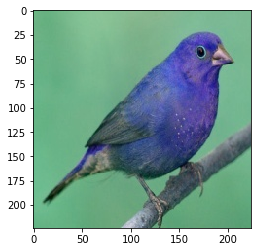

In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
image_path_list = ['work/birds/valid/AFRICAN FIREFINCH/1.jpg']
plt.imshow(cv2.imread('work/birds/valid/AFRICAN FIREFINCH/1.jpg'))


（3）定义数据集

```
# 读取label配置
%cd ~
import os
import random
import cv2
import numpy as np
import shutil
#import json

with open("work/birds/birds.csv",'r') as load_f:
    label_map = json.load(load_f)
    print(label_map)

```

In [3]:
import paddle
import numpy as np
import paddle.vision.transforms as T


class MyImageNetDataset(paddle.io.Dataset):
    def __init__(self,num_samples):
        super(MyImageNetDataset, self).__init__()

        self.num_samples = num_samples
        self.transform = T.Compose([
            T.Resize(size=(224, 224)),
            T.ToTensor(),
            T.Normalize(mean=127.5, std=127.5)])

    def __getitem__(self, index):
        image = np.random.randint(low=0, high=256, size=(512, 512, 3))
        

        image = image.astype('float32')
        

        image = self.transform(image)

        return image

    def __len__(self):
        return self.num_samples

In [4]:
import numpy as np
from PIL import Image
from paddle.vision.transforms import ColorJitter


transform = ColorJitter(0.4, 0.4, 0.4, 0.4)

for (root , dirs, files ) in os.walk("work/birds", topdown=False):
    for name in files:
        abs_name=os.path.join(root, name)
        print(abs_name)
        img = Image.open(abs_name)
        rotated_img = transform(img)
        print(rotated_img.size)
        fake_name=os.path.join(root,"ColorJitter_"+ name)
        print(fake_name)
        rotated_img.save(fake_name)


（4）聚合数据

In [21]:
data_path = "/home/work/birds"
train_folder = "train"
test_folder = "test"
data_list = []
for index in range(20):
    print(index,label_map[str(index)])
    sub_folder=label_map[str(index)]
    abs_sub_folder=os.path.join(data_path, train_folder,sub_folder)
    sub_list=os.listdir(abs_sub_folder)
    for sub_name in sub_list:
        data_list.append(os.path.join(train_folder, sub_folder, sub_name) + ' ' + str(index) + '\n')
    print("Finished train_folder: {}".format(sub_folder))
print("Finished data_list length: {}".format(len(data_list)))

val_ratio = 0.1

# save file
def save_file(list, txt):
    myfile=os.path.join('dataset',txt)
    if os.path.exists(myfile):
        os.remove(myfile)
    with open(myfile, "a") as f:
        f.writelines(list)


random.shuffle(data_list)
val_number = int(val_ratio * len(data_list))
train_list = data_list[val_number:]
val_list = data_list[0:val_number]
print("full data size: {}   train_list size: {}   val_list size: {}".format(len(data_list), len(data_list)-val_number,val_number))

save_file(train_list,  'train_list.txt')
save_file(val_list,  'test_list.txt')

NameError: name 'label_map' is not defined

## 三、模型介绍
* PaddleCV飞桨视觉模型库，提供大量高精度、高推理速度、经过产业充分验证的智能视觉模型，覆盖各类任务场景。PaddleClas、PaddleDet和PaddleSeg等端到端的开发套件，打通模型开发、训练、压缩、部署全流程，并支持超大规模分类等进阶功能，为开发者提供高效顺畅的开发体验。

![](https://ai-studio-static-online.cdn.bcebos.com/25542963e5284cf0a6be6f6fd3ca4845e1c3d578326c4a85a1338846bd51944a)


## 四、模型训练

（1）开始训练

In [5]:
%cd /home/aistudio/work/PaddleClas/

/home/aistudio/work/PaddleClas


```
# global configs
Global:
  checkpoints: null
  pretrained_model: null
  output_dir: ./output/
  device: gpu
  class_num: 275
  save_interval: 10
  eval_during_train: True
  eval_interval: 10
  epochs: 250
  print_batch_step: 10
  use_visualdl: False
  # used for static mode and model export
  image_shape: [3, 224, 224]
  # save_inference_dir: ./inference

# model architecture
Arch:
  name: ResNet50_vd
 
# loss function config for traing/eval process
Loss:
  Train:
    - CELoss:
        weight: 1.0
  Eval:
    - CELoss:
        weight: 1.0


Optimizer:
  name: Momentum
  momentum: 0.9
  lr:
    name: Cosine
    learning_rate: 0.0125
    warmup_epoch: 5
  regularizer:
    name: 'L2'
    coeff: 0.00001


# data loader for train and eval
DataLoader:
  Train:
    dataset:
      name: ImageNetDataset
      image_root: /home/aistudio/dataset/
      cls_label_path: /home/aistudio/dataset/train_list.txt
      transform_ops:
        - DecodeImage:
            to_rgb: True
            channel_first: False
        - RandCropImage:
            size: 224
        - RandFlipImage:
            flip_code: 1
        - RandAugment:
            num_layers: 2
            magnitude: 5
        - NormalizeImage:
            scale: 1.0/255.0
            mean: [0.485, 0.456, 0.406]
            std: [0.229, 0.224, 0.225]
            order: ''

    sampler:
      name: DistributedBatchSampler
      batch_size: 300
      drop_last: False
      shuffle: True
    loader:
      num_workers: 4
      use_shared_memory: True

  Eval:
    dataset: 
      name: ImageNetDataset
      image_root: /home/work/birds
      cls_label_path: /home/work/birds/test.txt
      transform_ops:
        - DecodeImage:
            to_rgb: True
            channel_first: False
        - ResizeImage:
            resize_short: 256
        - CropImage:
            size: 224
        - NormalizeImage:
            scale: 1.0/255.0
            mean: [0.485, 0.456, 0.406]
            std: [0.229, 0.224, 0.225]
            order: ''
    sampler:
      name: DistributedBatchSampler
      batch_size: 128
      drop_last: False
      shuffle: False
    loader:
      num_workers: 4
      use_shared_memory: True

Metric:
  Train:
    - TopkAcc:
        topk: [1, 5]
  Eval:
    - TopkAcc:
        topk: [1, 5]
```

（2）模型选取

In [7]:
!python  tools/train.py  -c  ppcls/configs/quick_start/MobileNetV3_large_x1_0.yaml

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/setuptools/depends.py:2: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
[2022/02/25 22:00:58] root INFO: 
==        PaddleClas is powered by PaddlePaddle !        ==
==                                                       ==
==   For more info please go to the following website.   ==
==                                                       ==
==       https://github.com/PaddlePaddle/PaddleClas      ==

[2022/02/25 22:00:58] root INFO: Arch : 
[2022/02/25 22:00:58] root INFO:     class_num : 102
[2022/02/25 22:00:58] root INFO:     name : MobileNetV3_large_x1_0
[2022/02/25 22:00:58] root INFO: DataLoader : 
[2022/02/25 22:00:58] root INFO:     Eval : 
[2022/02/25 22:00:58] root INFO:         dataset : 
[2022/02/25 22:00:58] root INFO:             cls_label_path : ./dataset/flowers102/val_list.txt
[2022/02/25 22:00:58] root INFO:  

（7）验证

In [9]:
!python -m paddle.distributed.launch \
    --gpus="0" \
    tools/eval.py \
    -o ARCHITECTURE.name="EfficientNetB0" \
    -o pretrained_model='./output/EfficientNetB0/best_model_train/ppcls'

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/setuptools/depends.py:2: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
usage: launch.py [-h] [--log_dir LOG_DIR] [--backend BACKEND]
                 [--nproc_per_node NPROC_PER_NODE] [--run_mode RUN_MODE]
                 [--ips IPS] [--servers SERVERS] [--workers WORKERS]
                 [--heter_workers HETER_WORKERS]
                 [--heter_devices HETER_DEVICES] [--worker_num WORKER_NUM]
                 [--server_num SERVER_NUM]
                 [--heter_worker_num HETER_WORKER_NUM] [--http_port HTTP_PORT]
                 [--elastic_server ELASTIC_SERVER] [--job_id JOB_ID] [--np NP]
                 [--scale SCALE] [--host HOST] [--force FORCE]
                 training_script ...
launch.py: error: unrecognized arguments: --gpus=0


（3）导出

In [10]:
!python tools/export_model.py \
    --model='EfficientNetB0' \
    --pretrained_model='./output_finetune/EfficientNetB0/best_model_finetune/ppcls' \
    --output_path='./output_finetune/EfficientNetB0_infer'

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/setuptools/depends.py:2: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
usage: generic-image-rec train script [-h] [-c CONFIG] [-o OVERRIDE]
                                      [-p PROFILER_OPTIONS]
generic-image-rec train script: error: unrecognized arguments: --model=EfficientNetB0 --pretrained_model=./output_finetune/EfficientNetB0/best_model_finetune/ppcls --output_path=./output_finetune/EfficientNetB0_infer


（4）预测

```
!python tools/infer/predict.py \
    -m=./output_finetune/EfficientNetB0_infer/model \
    -p=./output_finetune/EfficientNetB0_infer/params \
    -i=/home/aistudio/dataset/Butterfly20_test \
    # -i=./dataset/sgt/test/jpg \
    --use_gpu=1
```

```
# 读取,并转换为value，
%cd /home/aistudio
import fileinput

value_list = []
for line in fileinput.input("/home/aistudio/result_id.txt"):
    value_list.append(label_map[line.strip('\n')])
print(len(value_list))


```

(5)结果处理

```
# 保存
savename = '/home/aistudio/result.txt'
with open(savename, 'w', newline='') as f:
    for line in value_list:
        f.write(line+"\n")
```

## 五、总结
通过系列课程让本人对整体的项目流程有了一定的了解，但因本人基础知识欠缺，对初见的各种变量名和指令还待了解，对异常报错的经验还比较少，仅能做到通过参考相关文档模拟项目流程，故本人还应以后持续学习，进一步完善本项目及自己的深度学习知识体系。



参考资料：
       1.[30分钟玩转PaddleClas](https://paddleclas.readthedocs.io/zh_CN/latest/tutorials/quick_start.html)    2.[用PaddleClas解决蝴蝶分类](https://aistudio.baidu.com/aistudio/projectdetail/3525369?forkThirdPart=1)